# Exploring infectious disease dynamics with SIR models

## Numerically solving the SIR equations

As we saw in lecture, SIR-type models offer a powerful and general way of modeling infectious disease dynamics. Let's take another look at the differential equations for the standard SIR model:

\begin{eqnarray}
	\frac{dS}{dt} & = & -\beta S I  \\
	\frac{dI}{dt} & = & \beta S I - \gamma I \\ 
	\frac{dR}{dt} & = & \gamma I
\end{eqnarray}

Unfortunately, even though they look simple, we cannot analytically solve these equations for $S(t)$, $I(t)$ or $R(t)$ at a given time $t$. The incidence term $\beta S I$ makes this a ***nonlinear system*** of equations, which in general do not have simple analytical solutions. So intead, we need to ***numerically integrate (solve)*** these differential equations.

To integrate the equations, we need to consider the change in each variable over a small time step $\Delta t$. This turns out to be quite easy since the differential equations provide the derivative of each variable with respect time, or in other words, that variable's rate of change. To get the change in a variable, we just need to multiply the rate of change by $\Delta t$. For example, we can integrate the differential equation for $I$ from time $t$ to time $t + \Delta t$ as follows: 

%%latex
$$
    I(t + \Delta t) \approx I(t) + \frac{dI}{dt} \times \Delta t
$$

The problem with this basic scheme is that the amount of error we introduce will depend heavily on $\Delta t$. Modern numerical integration packages therefore use much more sophisticated integration schemes that can adaptively choose $\Delta t$ based on the rates of change. We will use [SciPy's integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html) package, which has very efficient methods for solving ODEs.

### Coding the SIR model in Python

We will implement the SIR model in Python. First we need to import some standard Python packages such as NumPy, SciPy and MatPlotLib. Make sure you hit ***Shift + Return*** in the following cell so that the lines of Python code are run through the interpreter.

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
%matplotlib inline

Next, we'll define the parameters of our model, including the transmission rate $\beta$, the recovery rate $\gamma$ and the overall host population size $N$:

In [2]:
beta = 0.3
gamma = 0.1
N = 1000.0

Again make sure you hit ***Shift + Return*** after each block of code so that the commands are evaluated. We will also create a grid of time points at which we will solve for each variable using NumPy's *linspace* function:

In [3]:
# A grid of time points (in days)
t = np.linspace(0, 100, 21)
print(t)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]


This creates a time point at zero and 20 evenly spaced time points between 0 and 100. Now we will set the initial conditions for each of the state variables, which we'll treat as frequencies. We will store all of these in one variable called *y_init*: 

In [4]:
# Initial conditions"
S_init = 999.0 / N
I_init = 1.0 / N
R_init = 0 / N
y_init = S_init, I_init, R_init
print("S = " + f'{S_init:.3f}; ' + "I = " + f'{I_init:.3f}; ' + "R = " + f'{R_init:.3f}')

S = 0.999; I = 0.001; R = 0.000


In order to numerically solve the ODE's in SciPy, we must first define a function that will compute and return the rate of change (i.e. the derivatives) for each variable. We do this in Python by using the keyword *def* to define the function and its inputs and the keyword *return* to set which variables are returned:

In [5]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return dS, dI, dR

With all of that, we can now use SciPy's *odeint* function to numerically integrate/solve our ODEs. Note the order of the input arguments here: first we list the function we are integrating *deriv*, then the initial conditions *y_init*, then the times at which we are solving *t*, and then a final tuple called *args* which supplies the other parameters in our model:

In [6]:
# Integrate the SIR equations over the time grid t.
ret = spi.odeint(deriv, y_init, t, args=(N, beta, gamma))

Now we can plot the SIR dynamics!

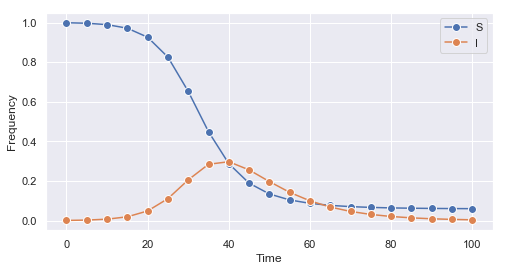

In [7]:
# Set up plot
import seaborn as sns # We will use seaborn to make the plots look slightly nicer
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
S, I, R = ret.T
ax.plot(t, S, 'o-', mew=1, ms=8, mec='w', label='S')
ax.plot(t, I, 'o-', mew=1, ms=8, mec='w', label='I')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.legend()

What happens if we vary the transmission rate $\beta$ and therefore also $R_{0}$? We can use a *for* loop to iterate through different values of $\beta$, recompute $R_{0}$ and then plot the  epidemic curve of prevalence over time:

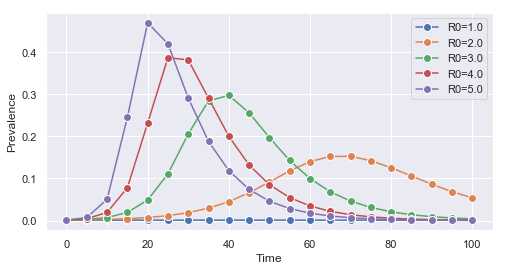

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
betas = np.linspace(0.1, 0.5, 5) # lets' try beta values of 0.1, 0.2, 0.3, 0.4 and 0.5
for beta in betas:
    R0 = beta / gamma
    ret = spi.odeint(deriv, y_init, t, args=(N,beta,gamma))
    S, I, R = ret.T
    ax.plot(t, I, 'o-', mew=1, ms=8, mec='w', label=f'R0={R0:.1f}')
ax.set_xlabel('Time')
ax.set_ylabel('Prevalence')
ax.legend()

As expected, the epidemic only takes off if $R_{0} > 1$ and we get larger epidemics as we increase $\beta$.

### Adding host demography

As we discussed in lecture, nothing really interesting can happen in the basic SIR model. The epidemic just grows until eventually it burns out due to a depletion of susceptible hosts. Let's add host births and deaths to the model so that we get a replenishment of susceptible hosts. Recall the SIR model with demography:  

%%latex
\begin{eqnarray}
    \frac{dS}{dt} & = & \nu -\beta S I - \mu S  \\
    \frac{dI}{dt} & = & \beta S I - (\gamma + \mu) I \\ 
    \frac{dR}{dt} & = & \gamma I - \mu R
\end{eqnarray}

Here, $\nu$ is the host birth rate and $\mu$ the death rate. We'll set this to reasonable values for humans. We will continue to specify time in days so rates are per day:

In [9]:
beta = 520/365 # per day
gamma = 1/7 # per day - so average infectious period is 1 week
N = 1000.0 # pop size
nu = 1/(70*365) # birth rate per day
mu = nu # death rate per day

The host lifespan is 70 years, but since we are working in time units of days, we multply this by 365 days to get the birth rate per day. We'll set $\mu=\nu$ so that the host population remains in demographic equilibrium. We will set our grid of time points over a much longer time scale (20 years) so we can see how the long-term dynamics unfold: 

In [10]:
# A grid of time points (in days)
t = np.linspace(0, 365*20, 100)

Now we need to set the initial conditions. We will continue work with frequencies for S, I and R. I've set *S_init* to $1/R_{0}$ so that we start close to the equilbrium number of susceptibles.

In [11]:
# Initial conditions"
R0 = beta / (gamma+mu)
S_init = 1. / R0
I_init = 1. / N
R_init = 1. - S_init - I_init
y_init = S_init, I_init, R_init
print("S = " + f'{S_init:.3f}; ' + "I = " + f'{I_init:.3f}; ' + "R = " + f'{R_init:.3f}')

S = 0.100; I = 0.001; R = 0.899


Now I'm going to make you do a little work. I've set up the #deriv# function for the SIR model with host births ***BUT*** I have not added deaths yet. See if you can modify the equations for the rate of change of each variable to include deaths:

In [12]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dS = nu - beta * S * I # Add deaths
    dI = beta * S * I - gamma * I # Add deaths
    dR = gamma * I # Add deaths
    return dS, dI, dR

As before, we can integrate our system of differential equations using *odeint*:

In [13]:
ret = spi.odeint(deriv, y_init, t, args=(N, beta, gamma))

And then plot the prevalence of the disease over a 20 year time span:

Text(0, 0.5, 'Prevalence')

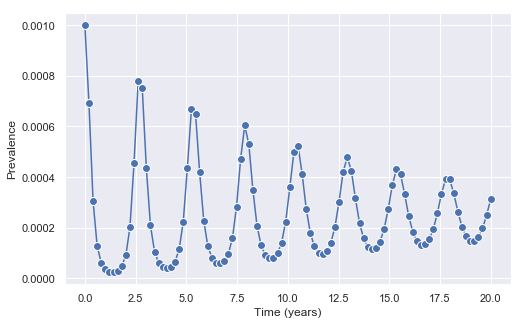

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
S, I, R = ret.T
ax.plot(t/365, I, 'o-', mew=1, ms=8, mec='w')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Prevalence')

As expected, we get fluctuations with damped oscillations as the system converges to equilbrium. How long do we need to run the dynamics before we hit equlibrium? You can vary the  number of years we run this for by changing the number of years in cell 27 above, then resolve the ODEs in cell 30 and plot again in cell 31.

You may also want to play around with changing the birth rate $\nu$. What happens if we increase or decrease the birth rate? The following code scales $\nu$ by 0.5, 1 and 2x.

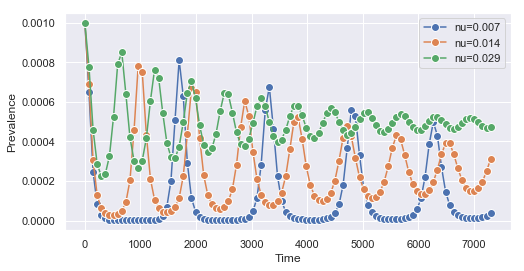

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nu = 1/(70*365) # birth rate per day
nus = [0.5*nu, 1.0*nu, 2*nu] # let's scale nu by 0.5X, 1X and 2X
for nu in nus:
    mu = nu # reset death rate equal to nu
    ret = spi.odeint(deriv, y_init, t, args=(N,beta,gamma))
    S, I, R = ret.T
    ax.plot(t, I, 'o-', mew=1, ms=8, mec='w', label=f'nu={365*nu:.3f}')
ax.set_xlabel('Time')
ax.set_ylabel('Prevalence')
ax.legend()

As you can see, changing the birth rate changes the periodicity of the oscillations. Higher birth rates lead to more frequent outbreaks with a smaller amplitude.

### Advanced: Koala chlamydia

Chlamydia is a major sexually transmitted disease in koalas which can lead to population declines through increased mortality and decreased fertility. Here we will consider a simple SI-type model with both male and female koalas. Since koalas are prodiguous herbivores, we will assume koalas compete with one another for food and that koala mortality naturally increases with greater population densities. The differential equations for our koala SI model are:

%%latex
\begin{eqnarray}
    \frac{dS_{f}}{dt} & = & r (S_{f} + (1-\alpha) I_{f}) - r S_{f} \frac{N}{K} - \beta_{mf} \frac{S_{f}}{N} I_{m} \\
    \frac{dS_{m}}{dt} & = & r (S_{f} + (1-\alpha) I_{f}) - r S_{m} \frac{N}{K} - \beta_{fm} \frac{S_{m}}{N} I_{f} \\
    \frac{dI_{f}}{dt} & = & \beta_{mf} \frac{S_{f}}{N} I_{m} - r I_{f} \frac{N}{K} \\ 
    \frac{dI_{m}}{dt} & = & \beta_{fm} \frac{S_{m}}{N} I_{f} - r I_{m} \frac{N}{K} \\
    N & = & S_{f} + S_{m} + I_{f} + I_{f}
\end{eqnarray}

$S_{f}$ and $S_{m}$ are the number of susceptible female and male koalas. Females reproduce at rate $r$, so the term $r(S_{f} + (1-\alpha) I_{f})$ is the rate at which both susceptible and infected females reproduce. The $\alpha$ parameter captures the reduced fertility of infected females, such that if $\alpha=1$, all infected females are completely infertile. We will assume that all koalas die at a rate $r \frac{N}{K}$, where $N$ is the total population size and $K$ is the carrying capacity, or maximum size, of the population that can be supported given the amount of food resources. Thus, the higher $N$ is relative to $K$, the more density-dependent mortality there is.

Now we need to choose some parameter values for our model:

In [16]:
r = 1.0 # koala reproductive rate
alpha = 0.4 # reduction in fertility due to infection
beta = np.array([[0.0,4.0],[4.6,0.0]]) # Transmission rates from Keeling & Rohani (pg 75)
K = 200 # carrying capacity

Notice that $\beta$ is a transmission rate matrix because we now have a structured host population with both males and females. I've set $\beta_{fm} = 4.0$ and $\beta_{mf} = 4.6$ such that male to female transmission is a little higher than female to male.

Next we will set the initial conditions. For now we will not include any infected males or females so that we can explore the host population dynamics in the absence of disease:

In [17]:
t = np.linspace(0, 20, 20) # grid of time points to simulate
Sf = 60
Sm = 80
If = 0
Im = 0
y_init = Sf, Sm, If, Im # initial conditions

The following code cell defines the #deriv# function for computeing the derivatives of the differential equation model:

In [18]:
def deriv(y, t, r, beta, alpha, K):
    Sf, Sm, If, Im = y
    N = Sf + Sm + If + Im
    dSf = r*(Sf + (1-alpha) * If) - r*Sf*(N/K) - beta[1,0] * Sf * Im / N
    dSm = r*(Sf + (1-alpha) * If) - r*Sm*(N/K) - beta[0,1] * Sm * If / N
    dIf = beta[1,0] * Sf * Im / N - r*If*(N/K)
    dIm = beta[0,1] * Sm * If / N - r*Im*(N/K)
    return dSf, dSm, dIf, dIm

Now we can numerically integrate the ODEs and plot the population dynamics:

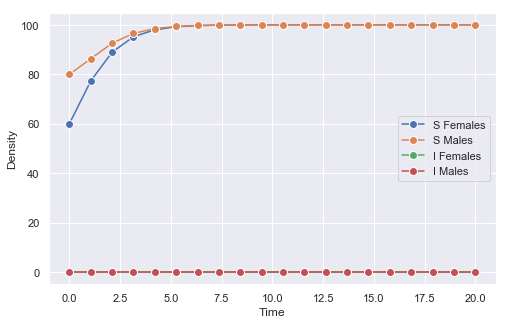

In [19]:
ret = spi.odeint(deriv, y_init, t, args=(r,beta,alpha,K)) # Integrate the SIR equations over the time grid, t.
Sf, Sm, If, Im = ret.T
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(t, Sf, 'o-', mew=1, ms=8, mec='w', label="S Females")
ax.plot(t, Sm, 'o-', mew=1, ms=8, mec='w', label="S Males")
ax.plot(t, If, 'o-', mew=1, ms=8, mec='w', label="I Females")
ax.plot(t, Im, 'o-', mew=1, ms=8, mec='w', label="I Males")
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.legend()

Remember we set $I_{f} = 0$ and $I_{m} = 0$, so we have not yet introduced the disease. In the absence of disease, the population quickly equilibrates to its carrying capacity ($K=200$). Now let's go back and seed the epidemic by including one infected male and female pair:

In [20]:
Sf = 60
Sm = 80
If = 1
Im = 1
y_init = Sf, Sm, If, Im # initial conditions

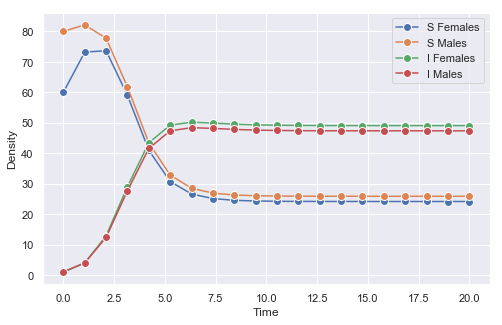

In [21]:
ret = spi.odeint(deriv, y_init, t, args=(r,beta,alpha,K)) # Integrate the SIR equations over the time grid, t.
Sf, Sm, If, Im = ret.T
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(t, Sf, 'o-', mew=1, ms=8, mec='w', label="S Females")
ax.plot(t, Sm, 'o-', mew=1, ms=8, mec='w', label="S Males")
ax.plot(t, If, 'o-', mew=1, ms=8, mec='w', label="I Females")
ax.plot(t, Im, 'o-', mew=1, ms=8, mec='w', label="I Males")
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.legend()

Now we see that the number of infected males and females quickly rises to an equilbrium value where about half of the population is infected. What happens if we vary $\alpha$, the reduction in fertility due to disease? Here, we will vary $\alpha$ between zero and one and then plot the total prevalence of the disease in both males and females for different $\alpha$ values:

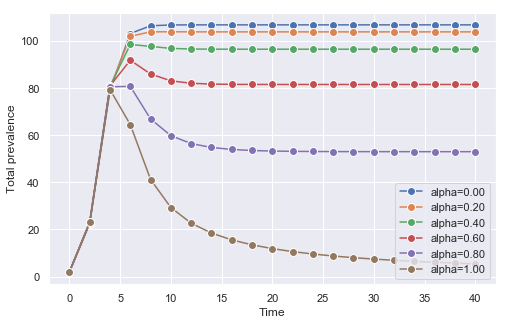

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
alphas = np.linspace(0.0, 1.0, 6) # lets' try beta values of 0.1, 0.2, 0.3, 0.4 and 0.5
t = np.linspace(0, 40, 21)
for alpha in alphas:
    ret = spi.odeint(deriv, y_init, t, args=(r,beta,alpha,K))
    Sf, Sm, If, Im = ret.T
    ax.plot(t, If+Im, 'o-', mew=1, ms=8, mec='w', label=f'alpha={alpha:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Total prevalence')
ax.legend()

We can see that high values of $\alpha$ where infected females have low fertility eventually causes disease prevalence to decline because high amounts of infertility causes the overall host population size to decline. Thus it would be benificial for the pathogen to reduce its virulence in terms of the infertility it causes.

However, for many infectious diseases there is a tradeoff between maximizing virulence and maximizing transmissibility. Maximizing transmissability generally requires high within host pathogen growth rates and population sizes, which will also tend to increase virulence. We can add such a tradeoff in our model by rescaling the transmission rates in $\beta$ by $\alpha$ such that we get a new transmission rate $\beta^{\ast}$ that linearly covaries with the virulence $\alpha$:   

%%latex
\begin{equation}
    \beta^{\ast} = \beta \times \alpha
\end{equation}

Now if we vary $\alpha$, we will also vary the transmission rates in $\beta$:

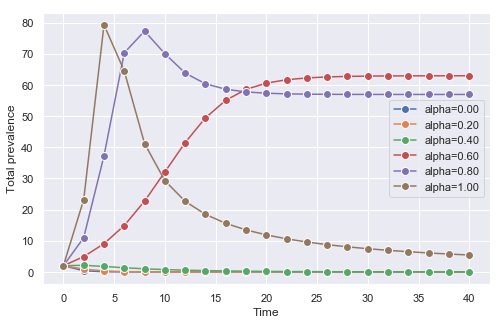

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
alphas = np.linspace(0.0, 1.0, 6) # lets' try beta values of 0.1, 0.2, 0.3, 0.4 and 0.5
t = np.linspace(0, 40, 21)
for alpha in alphas:
    beta_star = beta * alpha
    ret = spi.odeint(deriv, y_init, t, args=(r,beta_star,alpha,K))
    Sf, Sm, If, Im = ret.T
    ax.plot(t, If+Im, 'o-', mew=1, ms=8, mec='w', label=f'alpha={alpha:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Total prevalence')
ax.legend()

Now we can clearly see that there is an intermediate value of $\alpha$ about 0.6 that maximizes the long-term or equilibrium prevalence of chlamydia in the koala population. Do you think that the pathogen will evolve reduced virulence to maximize its long term fitness? Or would a less virulent strain of chlamydia always be outcompeted by a strain with greater virulence and therefore transmission potential?